In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import nibabel as nib
from torchvision.transforms import functional as F
from natsort import natsorted
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

import seaborn as sns
import vgg_train as vgg

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
model = vgg.vgg11_bn()
checkpoint_dir = '/media/youzhi/SSD/bme_project/checkpoints/Epoch_28_VLoss_0.0211.pth'
state_dict = torch.load(checkpoint_dir)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
root_dir = "/media/youzhi/SSD/bme_project/data"
folds_dir = [dir for dir in os.listdir(root_dir) if dir.startswith("fold")]
folds_dir = [os.path.join(root_dir, dir) for dir in folds_dir]
folds_dir = natsorted(folds_dir)
folds_dir

['/media/youzhi/SSD/bme_project/data/fold1',
 '/media/youzhi/SSD/bme_project/data/fold2',
 '/media/youzhi/SSD/bme_project/data/fold3',
 '/media/youzhi/SSD/bme_project/data/fold4',
 '/media/youzhi/SSD/bme_project/data/fold5',
 '/media/youzhi/SSD/bme_project/data/fold6',
 '/media/youzhi/SSD/bme_project/data/fold7',
 '/media/youzhi/SSD/bme_project/data/fold8',
 '/media/youzhi/SSD/bme_project/data/fold9',
 '/media/youzhi/SSD/bme_project/data/fold10']

In [6]:
dataloaders = []
for i in range(len(folds_dir)):
    fold_dir = folds_dir[i]
    dataset = vgg.CustomDataset(fold_dir, vgg.downsize_transform) #, downsize_transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    dataloaders.append(dataloader)
    print("fold", i+1, ": ", len(dataset))

fold 1 :  196
fold 2 :  188
fold 3 :  187
fold 4 :  185
fold 5 :  187
fold 6 :  185
fold 7 :  187
fold 8 :  182
fold 9 :  188
fold 10 :  187


In [7]:
def test_net(net, test_dataloader):
    net.to(device)
    net.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for i, (img, label) in enumerate(test_dataloader):
            img = img.to(device)
            y_pred = net(img)
            labels.append(label.numpy())
            predictions.append(y_pred.cpu().numpy())
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    return predictions, labels


In [8]:
pred, labels = test_net(model, dataloaders[9])

In [9]:
def softmax_argmax_index(x):
    # Subtracting the maximum value along the second axis for numerical stability
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    softmax_values = e_x / e_x.sum(axis=1, keepdims=True)
    return softmax_values
pred_softmax = softmax_argmax_index(pred)[0:,1]
labels_softmax = labels[:,1]

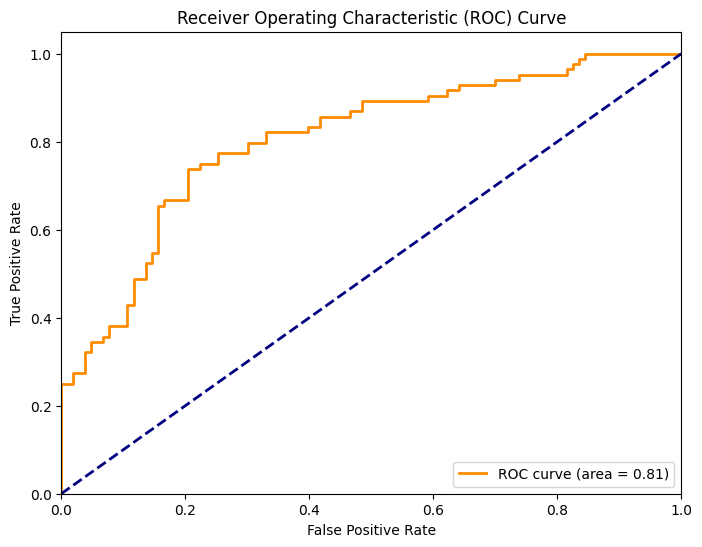

In [10]:
fpr, tpr, thres = roc_curve(labels_softmax, pred_softmax)
roc_auc = roc_auc_score(labels_softmax, pred_softmax)  # Calculate the ROC AUC score

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Include the AUC score in the label
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
with open('training_loss.txt', 'r') as file:
    lines = file.read().splitlines()

# Convert the list of strings to a NumPy array of floats
training_loss = np.array([float(line) for line in lines])

with open('valid_loss.txt', 'r') as file:
    lines = file.read().splitlines()

valid_loss = np.array([float(line) for line in lines])

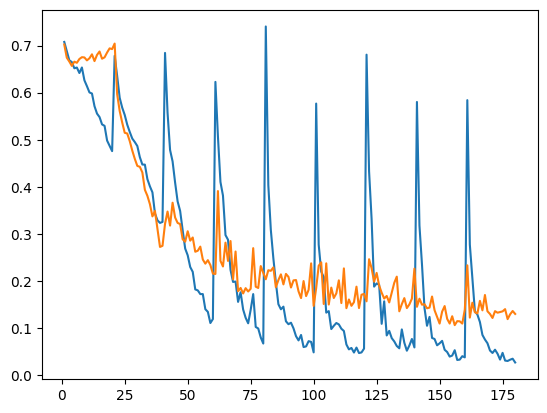

In [53]:
x = np.arange(1, 181)
plt.plot(x, training_loss)
plt.plot(x, valid_loss)